In [1]:
from ultralytics import YOLO
import torch
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import easyocr
from matplotlib.path import Path as mplPath
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2060'

In [20]:
#Images sourced from the internet for testing deployed model:
car_model = YOLO("best8.pt",task='detect')
char_model = YOLO("char_weights.pt",task='detect')
image_files = ["tests/Test_Model_1.jpeg", "tests/Test_Model_2.jpeg", "tests/Test_Model_3.jpeg", 
               "tests/Test_Model_4.jpeg", "tests/Test_Model_5.jpeg", "tests/Test_Model_6.jpeg"]

In [3]:
def extract_rois(results, target_label="Placa"):
    rois = []
    coordinates = []
    for result in results:
        for box in result.boxes:
            # Check if the detected object is a license plate (label: "Placa")
            if car_model.names[int(box.cls)] == target_label:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                roi = result.orig_img[y1-10:y2+10, x1-10:x2+10]  # Extract the ROI
                rois.append(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))  # Convert to RGB
                coordinates.append([x1-10, y1-10, x2+10, y2+10])
    return rois, coordinates

In [4]:
def preprocess_plate(roi):
    # # Convert ROI to grayscale
    # gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    
    # # Apply GaussianBlur to reduce noise
    # blurred = cv2.GaussianBlur(gray_roi, (5, 5), 0)
    
    # # Apply Otsu's binarization
    # _, binarized_roi = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    resized_Image = cv2.resize(roi, (700, 500), interpolation=cv2.INTER_AREA)

    return resized_Image

In [10]:
def Plates_Number(Model_Number):
    if char_model.names[Model_Number] in ["Bolivia", "_"]:
        return ''
    return (char_model.names[Model_Number])

In [21]:
def image_rect(img):
    re_img = cv2.resize(img, (780, 540),
                        interpolation=cv2.INTER_LINEAR)
    copy_re_img = re_img.copy()
    gray = cv2.cvtColor(re_img, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(
        gray, 150, 180, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    canny = cv2.Canny(thresh, 50, 100)
    contours = cv2.findContours(
        canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0]

    contours = sorted(contours, key=lambda x: cv2.contourArea(x),
                      reverse=True)[:10]

    points = []
    for c in contours:
        epsilon = 0.05 * cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, epsilon, True)
        if len(approx) == 4:
            if cv2.contourArea(approx) > 130000:
                cv2.drawContours(re_img, [approx], 0, (0, 255, 0), 3)
                for point in approx:
                    points.append((point[0][0], point[0][1]))
    if len(points) == 0:
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE,
                              np.ones((7, 7), np.uint8))
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,
                                np.ones((13, 13), np.uint8))
        canny = cv2.Canny(thresh, 50, 100)
        contours = cv2.findContours(
            canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0]

        contours = sorted(contours, key=lambda x: cv2.contourArea(x),
                        reverse=True)[:10]
        for c in contours:
            epsilon = 0.05 * cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, epsilon, True)
            if len(approx) == 4:
                if cv2.contourArea(approx) > 130000:
                    cv2.drawContours(re_img, [approx], 0, (0, 255, 0), 3)
                    for point in approx:
                        points.append((point[0][0], point[0][1]))
    try:
        menor_y = min(points, key=lambda p: p[1])[0]
        x_points = [p[0] for p in points]
        y_points = [p[1] for p in points]
        x_points.sort()
        y_points.sort()
        if menor_y <= x_points[0]+90:
            pts1 = np.float32([[x_points[1], y_points[0]], [x_points[3], y_points[1]],
                               [x_points[0], y_points[2]], [x_points[2], y_points[3]]])
        else:
            pts1 = np.float32([[x_points[0], y_points[1]], [x_points[2], y_points[0]],
                               [x_points[1], y_points[3]], [x_points[3], y_points[2]]])
        pts2 = np.float32([[0, 0], [x_points[3]-x_points[0], 0], [0, y_points[3]-y_points[0]], [x_points[3]-x_points[0], y_points[3]-y_points[0]]])
        M = cv2.getPerspectiveTransform(pts1, pts2)
        dst = cv2.warpPerspective(copy_re_img, M, (x_points[3]-x_points[0], y_points[3]-y_points[0]))
        return dst
    except Exception as e:
        return None
        print("Error:", e)


0: 384x640 5 Autos, 2 Placas, 5.2ms
Speed: 1.2ms preprocess, 5.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


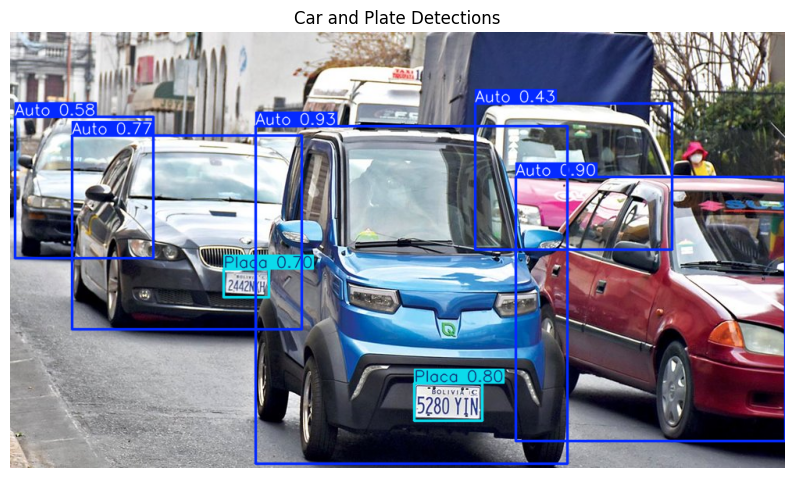

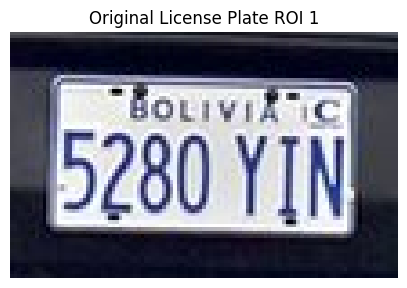

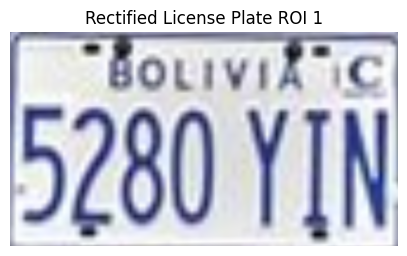

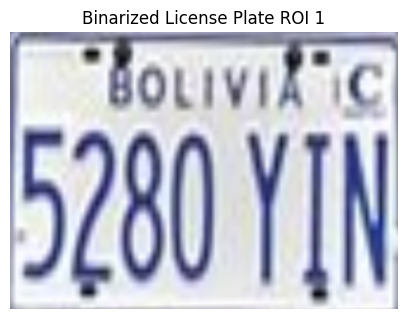


0: 480x640 1 0, 1 2, 1 5, 1 8, 1 I, 1 N, 1 O, 1 Y, 71.4ms
Speed: 1.5ms preprocess, 71.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)
[[np.float32(10.593976), '5'], [np.float32(99.03514), '2'], [np.float32(191.05046), '8'], [np.float32(284.6652), '0'], [np.float32(284.80945), 'O'], [np.float32(421.46735), 'Y'], [np.float32(515.13605), 'I'], [np.float32(595.9194), 'N']]
Detected characters on plate 1: 5280OYIN


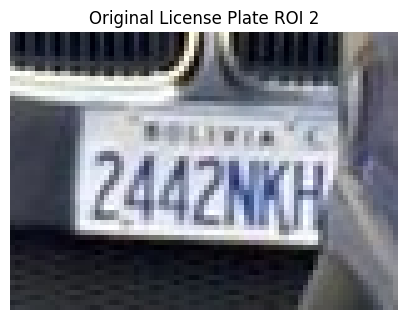

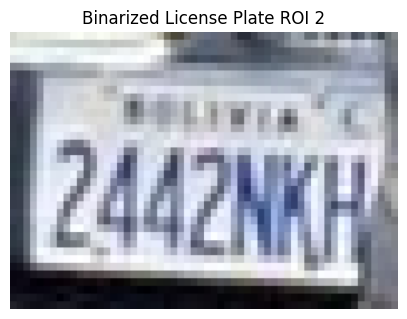


0: 480x640 1 2, 2 4s, 1 H, 1 K, 1 N, 1 Z, 45.4ms
Speed: 1.6ms preprocess, 45.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
[[np.float32(56.282497), '2'], [np.float32(140.72394), '4'], [np.float32(221.84276), '4'], [np.float32(303.85168), 'Z'], [np.float32(388.1755), 'N'], [np.float32(464.02676), 'K'], [np.float32(544.14374), 'H']]
Detected characters on plate 2: 244ZNKH

0: 384x640 1 Auto, 1 Placa, 5.0ms
Speed: 1.6ms preprocess, 5.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


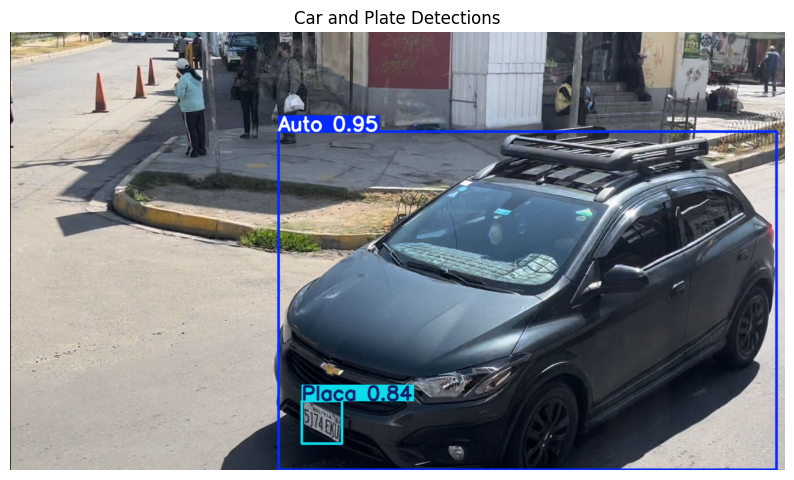

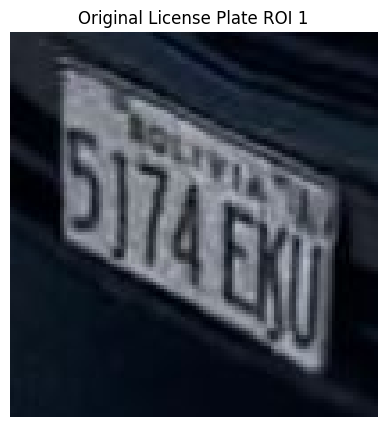

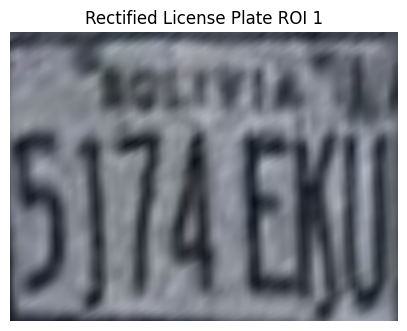

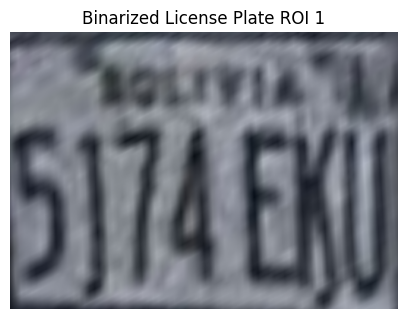


0: 480x640 1 1, 1 4, 1 5, 1 7, 1 E, 1 K, 1 U, 45.1ms
Speed: 1.8ms preprocess, 45.1ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)
[[np.float32(0.53792953), '5'], [np.float32(107.01304), '1'], [np.float32(180.61845), '7'], [np.float32(280.73373), '4'], [np.float32(413.5983), 'E'], [np.float32(510.56656), 'K'], [np.float32(596.0744), 'U']]
Detected characters on plate 1: 5174EKU

0: 384x640 1 Auto, 1 Placa, 4.6ms
Speed: 1.6ms preprocess, 4.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


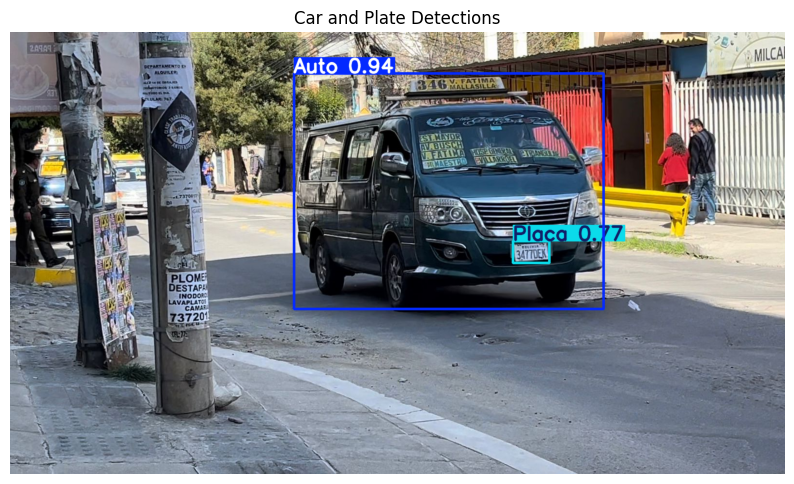

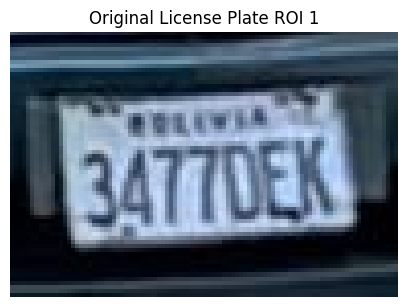

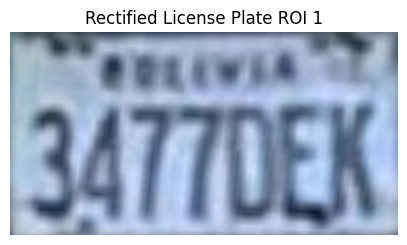

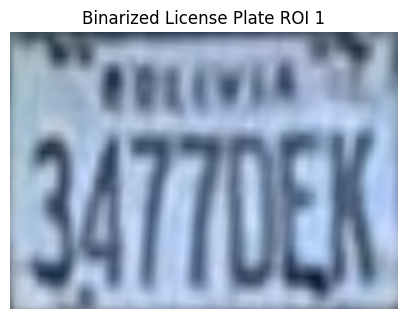


0: 480x640 1 3, 1 4, 2 7s, 1 E, 1 K, 1 O, 46.0ms
Speed: 1.6ms preprocess, 46.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)
[[np.float32(1.860832), '3'], [np.float32(101.559715), '4'], [np.float32(189.7159), '7'], [np.float32(285.49484), '7'], [np.float32(379.37164), 'O'], [np.float32(472.39246), 'E'], [np.float32(556.8521), 'K']]
Detected characters on plate 1: 3477OEK

0: 384x640 3 Autos, 1 Placa, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


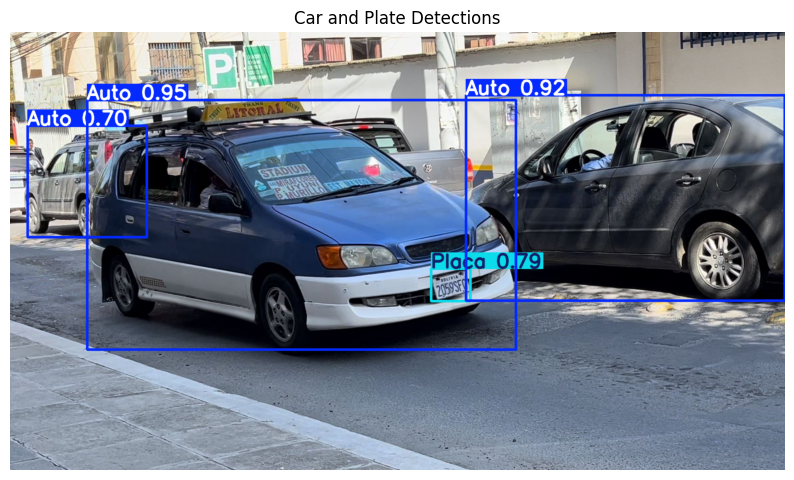

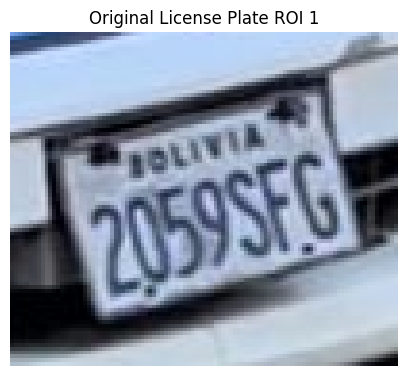

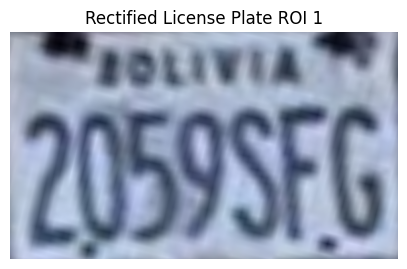

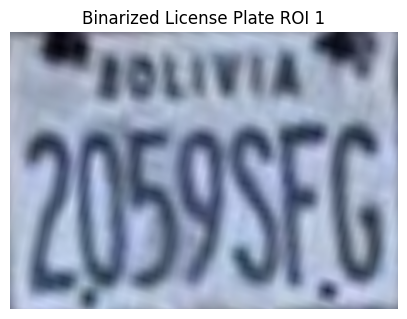


0: 480x640 1 0, 1 2, 1 5, 1 9, 1 F, 1 G, 1 S, 42.7ms
Speed: 1.7ms preprocess, 42.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)
[[np.float32(0.0), '2'], [np.float32(84.682915), '0'], [np.float32(184.71938), '5'], [np.float32(276.14703), '9'], [np.float32(371.68262), 'S'], [np.float32(462.5618), 'F'], [np.float32(555.49854), 'G']]
Detected characters on plate 1: 2059SFG

0: 384x640 1 Auto, 1 Placa, 5.5ms
Speed: 1.6ms preprocess, 5.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


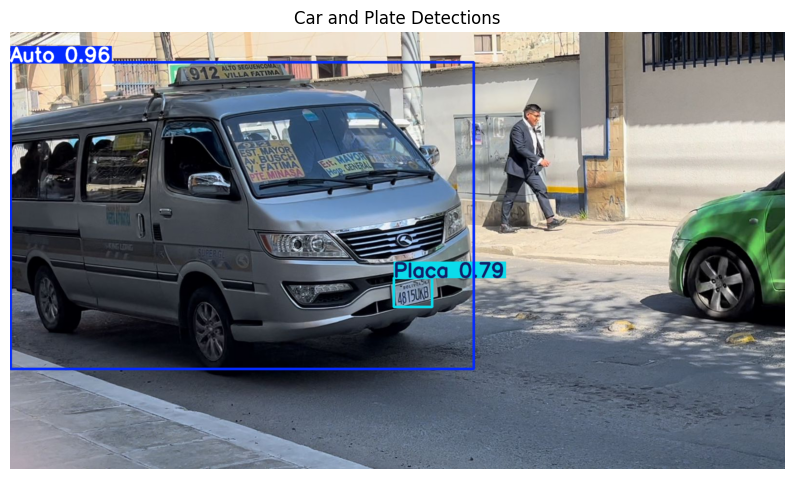

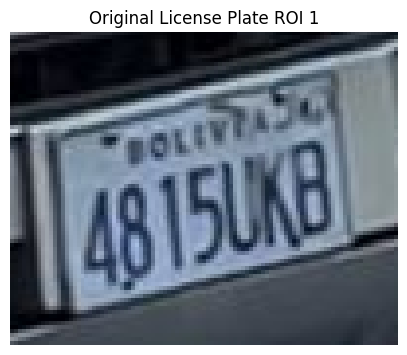

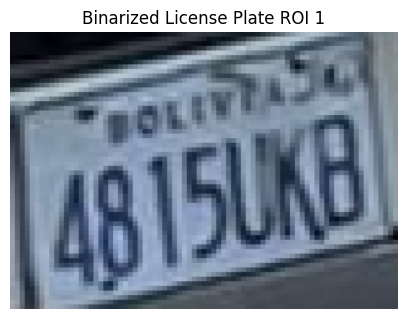


0: 480x640 1 1, 1 4, 1 5, 1 8, 1 B, 1 K, 1 U, 64.7ms
Speed: 2.0ms preprocess, 64.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)
[[np.float32(53.04651), '4'], [np.float32(132.48665), '8'], [np.float32(221.65564), '1'], [np.float32(296.18094), '5'], [np.float32(375.28088), 'U'], [np.float32(458.95905), 'K'], [np.float32(530.79254), 'B']]
Detected characters on plate 1: 4815UKB

0: 384x640 1 Auto, 1 Placa, 4.7ms
Speed: 1.7ms preprocess, 4.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


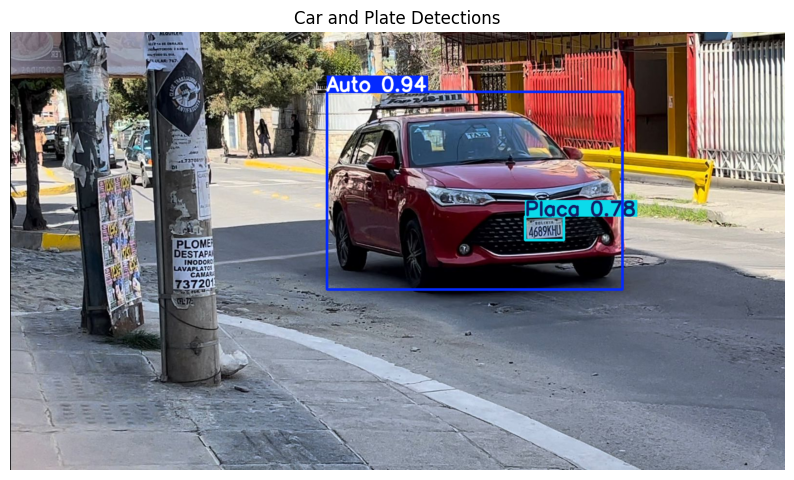

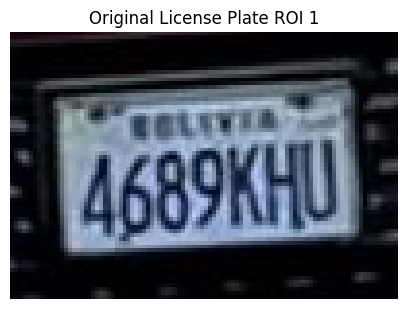

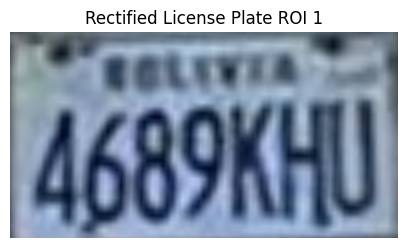

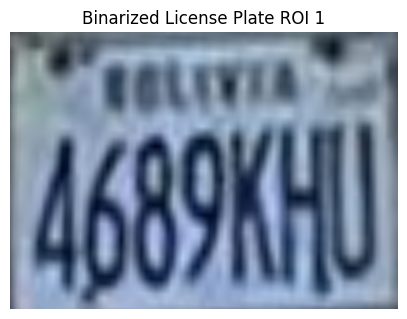


0: 480x640 1 4, 1 6, 1 8, 1 9, 1 H, 1 K, 1 U, 60.9ms
Speed: 2.7ms preprocess, 60.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)
[[np.float32(19.588766), '4'], [np.float32(112.81779), '6'], [np.float32(200.51447), '8'], [np.float32(292.081), '9'], [np.float32(380.4626), 'K'], [np.float32(464.88174), 'H'], [np.float32(558.36304), 'U']]
Detected characters on plate 1: 4689KHU


In [22]:
for img_path in image_files:
    # Read the image using OpenCV
    img = cv2.imread(img_path)
    
    # Run inference with the car_model to detect cars and plates
    results = car_model(img)
    
    # Display the car and plate detections
    for result in results:
        img_with_detections = result.plot()  # This draws bounding boxes and labels

        # Convert the image to RGB and display
        img_rgb = cv2.cvtColor(img_with_detections, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 10))
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title("Car and Plate Detections")
        plt.show()
    
    # Extract ROIs for license plates
    plate_rois, plate_coords = extract_rois(results, target_label="Placa")
    
    # If any license plates are detected
    if plate_rois:
        for i, roi in enumerate(plate_rois):
            # Display the extracted license plate ROI before preprocessing
            plt.figure(figsize=(5, 5))
            #plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
            plt.imshow(roi)
            plt.axis('off')
            plt.title(f"Original License Plate ROI {i+1}")
            plt.show()

            rect_roi = image_rect(roi)
            # rect_roi = None
            if rect_roi is not None:
                # Display the rectified license plate ROI
                plt.figure(figsize=(5, 5))
                plt.imshow(rect_roi)
                plt.axis('off')
                plt.title(f"Rectified License Plate ROI {i+1}")
                plt.show()

                # Preprocess the plate ROI with Otsu's binarization
                binarized_plate = preprocess_plate(rect_roi)
            else:
                roi = roi[10:roi.shape[0]-10, 10:roi.shape[1]-10]
                binarized_plate = preprocess_plate(roi)

            # Display the binarized license plate ROI
            plt.figure(figsize=(5, 5))
            plt.imshow(binarized_plate, cmap='gray')
            plt.axis('off')
            plt.title(f"Binarized License Plate ROI {i+1}")
            plt.show()

            # Convert the binarized image back to 3-channel (RGB) format for YOLO input
            # binarized_plate_rgb = cv2.cvtColor(binarized_plate, cv2.COLOR_GRAY2RGB)

            # Run inference with the char_model on the binarized plate ROI to detect characters
            char_results = char_model(binarized_plate)
            # print(f"Detected characters in plate ROI {i + 1}: {char_results}")

            # Print the detected characters from char_model
            detected_chars = []
            for char_result in char_results:
                for box in char_result.boxes:
                    # Assuming the class for characters is correctly labeled
                    coord_x = box.xyxy[0].cpu().numpy()
                    cls = int(box.cls[0].item())
                    Detected_Character = Plates_Number(cls)
                    if Detected_Character != '':
                        detected_chars.append([coord_x[0], Detected_Character])
                    
            
            # Join and print the detected characters
            detected_chars.sort(key=lambda x: x[0])
            print(detected_chars)
            Plate_Number = "".join([char[1] for char in detected_chars])
            print(f"Detected characters on plate {i + 1}: {Plate_Number}")
    else:
        print(f"No license plates found in {img_path}.")